In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import vnn
import torchvision
from imp import reload

In [2]:
#CIFAR

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def make_conv_net(mono):
    torch.manual_seed(42)
    model = nn.Sequential(vnn.Conv2d(10, 30, 96, 5, stride=2, mono=mono, first_layer=True),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 3, stride=2, mono=mono),
                          vnn.tReLU(),
                          vnn.Conv2d(10, 96, 96, 3, stride=1, mono=mono),
                          vnn.tReLU(),
                          vnn.Flatten(),
                          vnn.Linear(10, 1536, 1200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 1200, 600, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 600, 1, mono=mono)).to(0)
    return model

In [4]:
reload(vnn)

def eval_acc(model, loader):
    num_correct = 0
    total = 0
    for batch_idx, (data, labels) in enumerate(loader):
        input = vnn.expand_input_conv(data, 10).to(0)
        with torch.no_grad():
            out = model.forward(input)[..., 0]
        num_correct += (out.argmax(dim=1).cpu() == labels).int().sum().item()
        total += len(data)
    acc = num_correct / total
    return acc

def train_model_local(model, loader, filename):
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    acc_vals = np.array([])
    for epoch_idx in range(100):
        print(epoch_idx)
        epoch_loss = 0.
        epoch_correct = 0.
        for batch_idx, (data, labels) in enumerate(loader):
            input = vnn.expand_input_conv(data, 10).to(0)
            with torch.no_grad():
                out = model(input)[..., 0]
            loss = loss_fn(out, labels.to(0))
            epoch_loss += loss.item()
            epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
            opt.zero_grad()
            vnn.set_model_grads(model, out, labels.to(0))
            opt.step()
            for layer in model: layer.post_step_callback()
        print(epoch_loss / (batch_idx + 1))
        print(epoch_correct / 50000.)
        acc_vals = np.concatenate((acc_vals, [epoch_correct]))
        np.save(filename, acc_vals)
        
def train_model_bp(model, loader, filename):
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    acc_vals = np.array([])
    for epoch_idx in range(100):
        print(epoch_idx)
        epoch_loss = 0.
        epoch_correct = 0.
        for batch_idx, (data, labels) in enumerate(loader):
            input = vnn.expand_input_conv(data, 10).to(0)
            out = model(input)[..., 0]
            loss = loss_fn(out, labels.to(0))
            epoch_loss += loss.item()
            epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
            opt.zero_grad()
            loss.backward()
            opt.step()
            for layer in model: layer.post_step_callback()
        print(epoch_loss / (batch_idx + 1))
        print(epoch_correct / 50000.)
        acc_vals = np.concatenate((acc_vals, [epoch_correct]))
        np.save(filename, acc_vals)
        

In [5]:
conv = make_conv_net(False)
train_model_bp(conv, train_loader, "results/conv_bp.npy")

conv_mono = make_conv_net(True)
train_model_bp(conv_mono, train_loader, "results/conv_mono_bp.npy")

conv = make_conv_net(False)
train_model_local(conv, train_loader, "results/conv_local.npy")

conv_mono = make_conv_net(True)
train_model_local(conv_mono, train_loader, "results/conv_mono_local.npy")

0
Instantiated t with shape (10, 96, 14, 14)
Instantiated t with shape (10, 96, 6, 6)
Instantiated t with shape (10, 96, 4, 4)
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)
1.6882159142847866
0.39762
1
1.3811642333979497
0.51206
2
1.2480937658673357
0.55774
3
1.1568688701485734
0.59086
4
1.094610087859356
0.61638
5
1.0330162554445779
0.63702
6
0.987403260624927
0.65348
7
0.9471546432856098
0.6681
8
0.9088376431209048
0.67916
9
0.8781763473740014
0.6936
10
0.8492014464514944
0.70326
11
0.820817745707529
0.71194
12
0.7966424620060055
0.72012
13
0.7718319193176602
0.73164
14
0.7528035442542542
0.7348
15
0.7305407710087574
0.7454
16
0.7194376480396446
0.74718
17
0.7106522538168046
0.75012
18
0.6940668244343584
0.75802
19
0.6817656561084415
0.76248
20
0.6693438264872412
0.76554
21
0.6594862481364814
0.76738
22
0.6521987639882071
0.77084
23
0.6459245998078905
0.7713
24
0.6351586953758279
0.77822
25
0.6273838129189923
0.78342
26
0.6224829884593749
0.7816
27
0.620219

12772.685084194174
0.36724
60
10362.149181785486
0.37028
61
12537.414163028492
0.36944
62
12756.035101614949
0.36858
63
16305.612655756724
0.3762
64
14408.690728307076
0.37436
65
17297.008086143553
0.37272
66
12773.025372205184
0.3739
67
18597.19426194603
0.37146
68
12291.050891612802
0.37458
69
14007.802833030291
0.3749
70
23315.838513152376
0.37932
71
28245.01804704983
0.37534
72
19009.84206599165
0.3734
73
20947.48278090533
0.3789
74
33400.310914646936
0.38076
75
20228.654215702925
0.3828
76
28445.14281914362
0.3803
77
24086.949574346127
0.38212
78
26019.8373461477
0.3763
79
28448.247271057284
0.38104
80
26252.630984567317
0.38222
81
33903.4291433349
0.38748
82
34733.24586240959
0.38556
83
34828.080575147855
0.3853
84
33626.75958080243
0.38318
85
21591.18732860204
0.3951
86
17003.867201861212
0.386
87
26410.673182494804
0.3857
88
24826.046383908946
0.39322
89
29475.942781804468
0.39398
90
37498.94914600733
0.39886
91
28548.897374770222
0.38872
92
40240.93125880405
0.389
93
34549.560

In [3]:
x1 = np.load("results/conv_bp.npy")
x2 = np.load("results/conv_mono_bp.npy")
x3 = np.load("results/conv_local.npy")
x4 = np.load("results/conv_mono_local.npy")



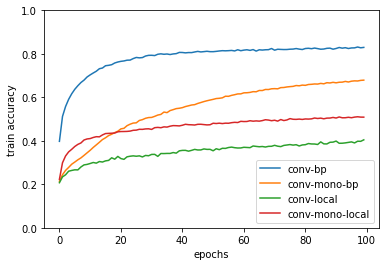

In [5]:
N = 50000.
plt.plot(x1/N, label="conv-bp")
plt.plot(x2/N, label="conv-mono-bp")
plt.plot(x3/N, label="conv-local")
plt.plot(x4/N, label="conv-mono-local")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("train accuracy")
plt.xlabel("epochs")
plt.savefig("figs/conv_acc.pdf", bbox_inches="tight")
